<a href="https://colab.research.google.com/github/trilgar/AFED/blob/main/AFED_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
from collections import Counter
from sklearn import tree

# Підготовка датасету

## функція для ковертації бінарних категоріальних змінних в 1 та 0:

In [74]:
def convert_binary_class_to_number(class1, class2):
  def result(clazz): 
    if(class1 == clazz):
      return 0
    elif(class2 == clazz):
      return 1
    else:
      return NaN
  return result

## Зчитуємо файл:

In [75]:
df = pd.read_csv('/content/Data_Base_I not disc.txt', sep='\t', lineterminator='\n')
df = df.rename(columns= {'Result\r': 'result','�redit_sum': 'Credit_sum' }, inplace=False)
df.result = df.result.apply(lambda name: name[:len(name)-1])
df

,Gender,Age,Credit_sum,Currency,Term_of_crediting_in day,Interest rate_%,Duration_of_stay_in_a_sity,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_kompany,Income_customer,Costs_customer,goal_credit,result
0,Female,27,850,UAH,360,18,24_60,SINGLE,c0,PE,24_60,24_60,FS,100_9999,674,362,consumer_credit,good
1,Male,35,400,USD,240,12,24_60,SINGLE,c0,AS,24_60,24_60,FMG,51_100,690,342,consumer_credit,bad
2,Male,43,2750,UAH,240,14,24_60,MARRIED,c1,AS,12_18,12_24,OT,31_50,1588,767,consumer_credit,good
3,Male,43,15000,USD,1800,15,60_120,MARRIED,c1,TM,24_60,24_60,OT,0_5,4869,800,consumer_credit,bad
4,Male,28,2500,UAH,1080,18,60_120,SINGLE,c0,PE,0_3,0_12,FS,100_9999,637,382,consumer_credit,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14987,Male,38,76500,USD,2520,13,12_24,DIVORCED,c1,TM,18_24,12_24,WB,31_50,25320,1400,flat,good
14988,Female,43,41528,USD,1800,13,120_9999,MARRIED,c2,TM,60_120,60_120,WB,6_15,10113,1850,flat,good
14989,Male,46,60000,USD,1080,14,120_9999,SINGLE,c0,AS,6_12,0_12,WB,31_50,16222,462,consumer_credit,good
14990,Male,30,79000,USD,2520,13,120_9999,MARRIED,c0,TM,6_12,0_12,OT,0_5,19671,1320,consumer_credit,good


## Конвертуємо бінарні категоріальні змінні

In [76]:
df.Gender = df.Gender.apply(convert_binary_class_to_number('Female', 'Male'))
df.result = df.result.apply(convert_binary_class_to_number('bad', 'good'))
df

,Gender,Age,Credit_sum,Currency,Term_of_crediting_in day,Interest rate_%,Duration_of_stay_in_a_sity,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_kompany,Income_customer,Costs_customer,goal_credit,result
0,0,27,850,UAH,360,18,24_60,SINGLE,c0,PE,24_60,24_60,FS,100_9999,674,362,consumer_credit,1
1,1,35,400,USD,240,12,24_60,SINGLE,c0,AS,24_60,24_60,FMG,51_100,690,342,consumer_credit,0
2,1,43,2750,UAH,240,14,24_60,MARRIED,c1,AS,12_18,12_24,OT,31_50,1588,767,consumer_credit,1
3,1,43,15000,USD,1800,15,60_120,MARRIED,c1,TM,24_60,24_60,OT,0_5,4869,800,consumer_credit,0
4,1,28,2500,UAH,1080,18,60_120,SINGLE,c0,PE,0_3,0_12,FS,100_9999,637,382,consumer_credit,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14987,1,38,76500,USD,2520,13,12_24,DIVORCED,c1,TM,18_24,12_24,WB,31_50,25320,1400,flat,1
14988,0,43,41528,USD,1800,13,120_9999,MARRIED,c2,TM,60_120,60_120,WB,6_15,10113,1850,flat,1
14989,1,46,60000,USD,1080,14,120_9999,SINGLE,c0,AS,6_12,0_12,WB,31_50,16222,462,consumer_credit,1
14990,1,30,79000,USD,2520,13,120_9999,MARRIED,c0,TM,6_12,0_12,OT,0_5,19671,1320,consumer_credit,1


## Переводимо всі інші категоріальні змінні до one-hot формату

In [77]:
df = pd.get_dummies(df)
df

,Gender,Age,Credit_sum,Term_of_crediting_in day,Interest rate_%,Income_customer,Costs_customer,result,Currency_EUR,Currency_UAH,Currency_USD,Duration_of_stay_in_a_sity _0_3,Duration_of_stay_in_a_sity _120_9999,Duration_of_stay_in_a_sity _12_24,Duration_of_stay_in_a_sity _24_60,Duration_of_stay_in_a_sity _3_6,Duration_of_stay_in_a_sity _60_120,Duration_of_stay_in_a_sity _6_12,Maritial_status_CIVILMARRIAGE,Maritial_status_DIVORCED,Maritial_status_MARRIED,Maritial_status_SINGLE,Children_c0,Children_c1,Children_c2,Children_c3,Job_position_AS,Job_position_MM,Job_position_PE,Job_position_SP,Job_position_TM,Tenure_with_current_employer_0_3,Tenure_with_current_employer_120_9999,Tenure_with_current_employer_12_18,Tenure_with_current_employer_18_24,Tenure_with_current_employer_24_60,Tenure_with_current_employer_3_6,Tenure_with_current_employer_60_120,Tenure_with_current_employer_6_12,Term_of_existence_of_enterprise_0_12,Term_of_existence_of_enterprise_120_9999,Term_of_existence_of_enterprise_12_24,Term_of_existence_of_enterprise_24_60,Term_of_existence_of_enterprise_60_120,Company_type_AG,Company_type_ALC,Company_type_AP,Company_type_ASTL,Company_type_CA,Company_type_CI,Company_type_EC,Company_type_EOG,Company_type_ESB,Company_type_FMCG,Company_type_FMG,Company_type_FS,Company_type_HI,Company_type_HRC,Company_type_ITT,Company_type_LI,Company_type_MFC,Company_type_MPP,Company_type_OT,Company_type_PSL,Company_type_RE,Company_type_TSPW,Company_type_WB,Number_of_employees_in_kompany _0_5,Number_of_employees_in_kompany _100_9999,Number_of_employees_in_kompany _31_50,Number_of_employees_in_kompany _51_100,Number_of_employees_in_kompany _6_15,goal_credit_auto,goal_credit_consumer_credit,goal_credit_consumer_credit,goal_credit_flat,goal_credit_house,goal_credit_overhaul
0,0,27,850,360,18,674,362,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,35,400,240,12,690,342,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1,43,2750,240,14,1588,767,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,1,43,15000,1800,15,4869,800,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,28,2500,1080,18,637,382,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14987,1,38,76500,2520,13,25320,1400,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
14988,0,43,41528,1800,13,10113,1850,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
14989,1,46,60000,1080,14,16222,462,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
14990,1,30,79000,2520,13,19671,1320,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## Обираємо тестову та навчальну вибірки у співвідношенні 25% до 75%

In [78]:
feature_names = list(df.columns)
feature_names.remove('result')

In [79]:
train = df.sample(frac=0.75)
test = df.drop(train.index)

## Обираємо метод бототьби з нерівномірністю вибірки (вкоротити датасет або клонувати недостаючі погані кейси)

In [80]:
def shorten_dataset(train_dataset): 
  bad = train_dataset[train_dataset.result == 0]
  good = train_dataset[train_dataset.result == 1]
  good = good.iloc[: bad.shape[0]]
  return pd.concat([good, bad])

def enlarge_dataset(train_dataset):
  bad = train_dataset[train_dataset.result == 0]
  good = train_dataset[train_dataset.result == 1]
  bad = pd.concat([bad]* math.floor(good.shape[0]/bad.shape[0]), ignore_index=True)
  return pd.concat([good, bad])

In [81]:
# train = shorten_dataset(train)
train = enlarge_dataset(train)

X_train = train[feature_names]
Y_train = train['result']
X_test = test[feature_names]
Y_test = test['result']

# Побудова дерева рішень

## Побудова дерева та навчання на тренувальній вибірці

In [82]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [83]:
Counter(Y_test)[0]

207

## Функція що визначає точність моделі на тестовій вибірці та помилки першого і другого роду

In [84]:
def calculate_accuracy(predict, expected):
  accuracy = 0
  type1_error = 0
  type2_error = 0
  for error in predict - expected:
    if(error == 0):
      accuracy += 1
    elif(error == -1):
      type2_error += 1
    elif(error == 1):
      type1_error += 1
      
  return accuracy/len(Y_test), type1_error/Counter(Y_test)[0], type2_error/Counter(Y_test)[1]

## Точність нашого дерева рішень .За замовчуванням поріг стоїть на 0.5. Тобто, обирається найбільш вірогідний варіант незалежно від того, наскільки відрізняються вірогідності класів.

In [85]:
accuracy = calculate_accuracy(clf.predict(X_test), Y_test)

print('Total Accuracy:', accuracy[0])
print('Type 1 error:', accuracy[1])
print('Type 2 error:', accuracy[2]) 

Total Accuracy: 0.852187833511206
Type 1 error: 0.5217391304347826
Type 2 error: 0.12595312058740468


## Візуалізація дерева у вигляді графу (змінних дуже багато, тому корисність такої візуалізації сумнівна)

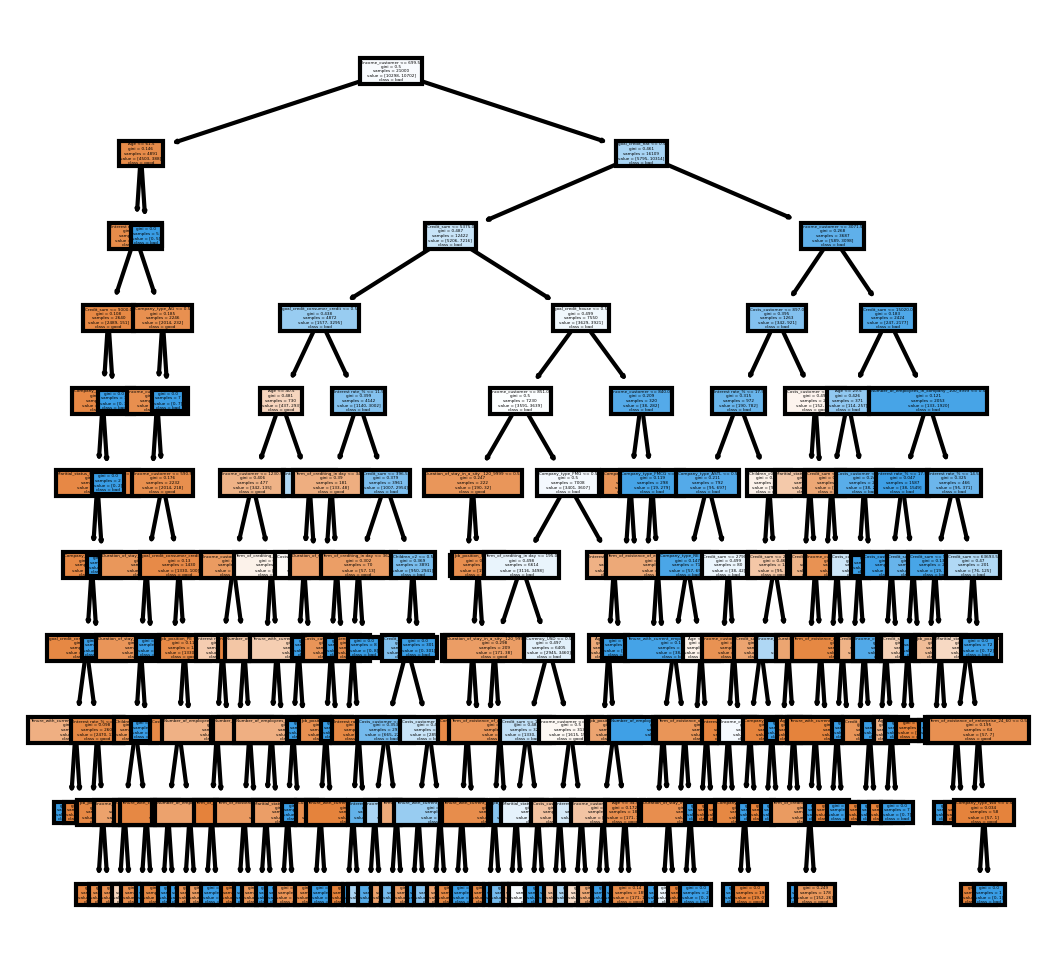

In [86]:
class_names=['good', 'bad']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = feature_names, 
               class_names=class_names,
               filled = True);
fig.savefig('imagename.png')

## Для наглядності побудуємо дерево з обмеженням на глибину = 2:


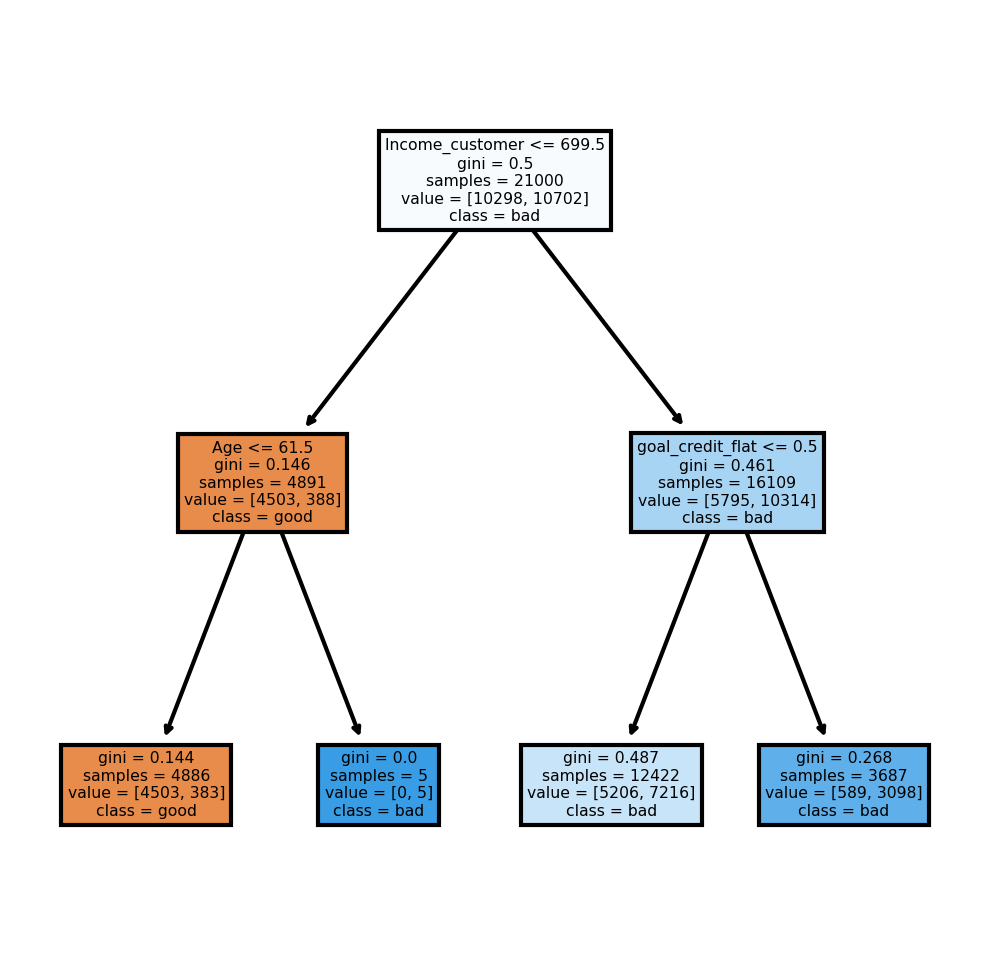

In [87]:
clf2 = DecisionTreeClassifier(random_state=0, max_depth=2)
clf2.fit(X_train, Y_train)
class_names=['good', 'bad']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf2,
               feature_names = feature_names, 
               class_names=class_names,
               filled = True);
fig.savefig('imagename2.png')

# Прогнозування при заданому порозі:

## Функція що класифікує беручи до уваги вказаний поріг вірогідності істинності нульової гіпотези (в нашому випадку - вірогідність хорошого кредитного випадку) 

In [88]:
def choose_with_threashold(threashold, test_data):
  def set_threachold(bad, good):
    if(good >= threashold):
      return 1
    else:
      return 0

  return np.array([set_threachold(x, y) for x, y in clf.predict_proba(test_data)])

## Таблиця точності моделі в залежності від заданого порогу:

In [89]:
accuracy = []
type_1_error = []
type_2_error = []
threashold = []
for ts in np.arange(0.95, 0.49, -0.05):
  accuracy_ = calculate_accuracy(choose_with_threashold(ts, X_test), Y_test)
  accuracy.append(accuracy_[0])
  type_1_error.append(accuracy_[1])
  type_2_error.append(accuracy_[2])
  threashold.append(ts)

In [90]:
predictions_with_threshold = pd.DataFrame(data = {'Accuracy': accuracy, 'Type 1 error': type_1_error, 'Type 2 error': type_2_error}, index=threashold)

In [91]:
predictions_with_threshold

,Accuracy,Type 1 error,Type 2 error
0.95,0.408751,0.183575,0.615080
0.90,0.408751,0.183575,0.615080
0.85,0.527748,0.222222,0.486868
0.80,0.527748,0.222222,0.486868
0.75,0.631270,0.280193,0.373906
0.70,0.658218,0.289855,0.344818
0.65,0.658218,0.289855,0.344818
0.60,0.762006,0.391304,0.229031
0.55,0.762006,0.391304,0.229031
0.50,0.852188,0.521739,0.125953


# Висновки

Як бачимо дерева рішень трохи краще показали себе у прогнозуванні (у баєсовських мережах точність була не більше 70%).   
За замовчуванням ми розглянули випадок коли ми просто визначали клас як найбільш вірогідний. Як бачимо помилка першого роду (тобто false positive) склала аж 52%, тобто більша частина "поганих" кредитів визнавалася хорошими. Звичайно ми як банк не згодні з такими прогнозами.   
Для банку помилка першого роду коштує набагато більше ніж помилка другого (false negative). Тому було розглянуто декілька випадків прогнозування з порогами вірогідності.   
Як бачимо при порозі 95% помилка першого роду склала 18%. Це звичайно непогано, проте щоб добитися такого результату ми відсіяли аж 60% "хороших" позичальників. Звісно пріорітети для кожного банку свої, проте я вважаю, що брати більше 0.65 недоречно , оскільки далі помилка першого роду падає дуже повільно, а от помилка другого роду зростає дуже швидко. 